In [2]:
from gurobipy import *
import numpy as np
import pandas as pd
from Hourbid import *
from Fibid import *
from blockbid import *


In [3]:
HourBid()[1]

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,12,1000,1,S,156716.0,2000.00,1,NaN
1,12,999,1,S,156751.0,1996.76,1,NaN
2,12,998,1,S,156767.0,1995.25,1,NaN
3,12,997,1,S,156794.0,1992.78,1,NaN
4,12,996,1,S,156822.0,1990.18,1,NaN
...,...,...,...,...,...,...,...,...
23995,242,5,24,S,199186.0,6.50,1,NaN
23996,242,4,24,S,199270.0,5.22,1,NaN
23997,242,3,24,S,199466.0,2.79,1,NaN
23998,242,2,24,S,199637.0,1.29,1,NaN


In [4]:
BS_bids = Blockbid()[0]
BD_bids = Blockbid()[1]
HS_bids = HourBid()[0]
HD_bids = HourBid()[1]
FS_bids = Fibid()[0]
FD_bids = Fibid()[1]

In [5]:
HS_bids

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,11,1,1,S,183892.0,0.00,1,NaN
1,11,2,1,S,184057.0,0.21,1,NaN
2,11,3,1,S,184504.0,2.89,1,NaN
3,11,4,1,S,184715.0,5.23,1,NaN
4,11,5,1,S,184884.0,7.59,1,NaN
...,...,...,...,...,...,...,...,...
23995,241,996,24,S,199936.0,1990.00,1,NaN
23996,241,997,24,S,199949.0,1992.00,1,NaN
23997,241,998,24,S,199973.0,1995.83,1,NaN
23998,241,999,24,S,199980.0,1996.95,1,NaN


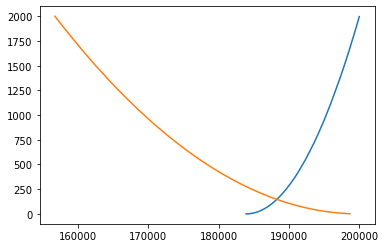

In [6]:
import matplotlib.pyplot as plt
plt.plot(HS_bids['Quantity'][0:999],HS_bids['price'][0:999])
plt.plot(HD_bids['Quantity'][0:999],HD_bids['price'][0:999])
plt.show()

In [7]:
np.shape(BD_bids)

(120, 8)

In [8]:
L_D = len(BD_bids)
L_S = len(BS_bids)

In [9]:
BD_bids

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,1220,1,1,B,331.0,541.64,10,1232.0
1,1217,1,3,B,821.0,712.70,22,NaN
2,1210,1,2,B,363.0,601.03,7,1217.0
3,1219,1,9,B,261.0,807.70,13,1235.0
4,1105,1,5,B,198.0,641.75,19,NaN
...,...,...,...,...,...,...,...,...
115,1090,1,12,B,847.0,609.05,9,1096.0
116,1099,1,4,B,473.0,649.79,15,NaN
117,1097,1,1,B,554.0,786.30,12,NaN
118,1096,1,4,B,267.0,764.57,20,NaN


In [10]:
BD_bids['ID']

0      1220
1      1217
2      1210
3      1219
4      1105
       ... 
115    1090
116    1099
117    1097
118    1096
119    1202
Name: ID, Length: 120, dtype: int64

In [11]:
NoneChild_D=[]
Child_D = []
Parent_D=[]
NoneChild_S=[]
Child_S=[]
Parent_S=[]
for i in range(L_D):
    if BD_bids.isnull()['LinkID'][i] == True:
        NoneChild_D.append(i)
    else:
        Parent_D.append(np.where(BD_bids['ID']==BD_bids['LinkID'][i])[0][0])
        Child_D.append(i)
for i in range(L_S):
    if BS_bids.isnull()['LinkID'][i] == True:
        NoneChild_S.append(i)
    else:
        Parent_S.append(np.where(BS_bids['ID']==BS_bids['LinkID'][i])[0][0])
        Child_S.append(i)

In [12]:
Delta_S = np.zeros([L_S,24])


Delta_D = np.zeros([L_D,24])
BD_bids  = Blockbid()[1]
for i in range (L_D):
    if BD_bids['Hour'][i]+BD_bids['Duration'][i]<=25:
        Delta_D[i,BD_bids['Hour'][i]-1:(BD_bids['Hour'][i]+BD_bids['Duration'][i])-1] = 1

BS_bids = Blockbid()[0]
for i in range (L_S):
    if BS_bids['Hour'][i]+BS_bids['Duration'][i]<=25:
        Delta_S[i,BS_bids['Hour'][i]-1:(BS_bids['Hour'][i]+BS_bids['Duration'][i])-1] = 1

In [13]:
def find_F(Del,leng,bids):
    Res = [[] for i in range(24)]
    Res_max = [[] for i in range(24)]
    Res_min = [[] for i in range(24)]
    for i in range (24):
        for j in range(leng):
            if Del[j,i] == 1:
                Res[i].append(bids['price'][j])
    for i in range(24):
        Res_max[i] = np.max(Res[i])
        Res_min[i] = np.min(Res[i])
    return(Res_max,Res_min)

FD_min = np.min(FD_bids['price'])
FD_max = np.max(FD_bids['price'])
FS_min = np.min(FS_bids['price'])
FS_max = np.max(FS_bids['price'])

In [14]:
HD_bids['price'][HIndex_D[1][1]]

0.0

In [16]:
DMax_Res = [[] for i in range(24)]
Dm_Res = [[] for i in range(24)]
SMax_Res = [[] for i in range(24)]
Sm_Res = [[] for i in range(24)]

for i in range(24):
    DMax_Res[i].append(HD_bids['price'][HIndex_D[i][0]])
    DMax_Res[i].append(find_F(Delta_D,L_D,BD_bids)[0][i])
    DMax_Res[i].append(FD_max)
    
for i in range(24):
    SMax_Res[i].append(HS_bids['price'][HIndex_S[i][1]])
    SMax_Res[i].append(find_F(Delta_S,L_S,BS_bids)[0][i])
    SMax_Res[i].append(FS_max)
    
for i in range(24):
    Dm_Res[i].append(HD_bids['price'][HIndex_D[i][1]])
    Dm_Res[i].append(find_F(Delta_D,L_D,BD_bids)[1][i])
    Dm_Res[i].append(FD_min)
    
for i in range(24):
    Sm_Res[i].append(HS_bids['price'][HIndex_S[i][0]])
    Sm_Res[i].append(find_F(Delta_S,L_S,BS_bids)[1][i])
    Sm_Res[i].append(FS_min)

In [17]:
def findmin(num1,num2,num3):
    
    return(min([num1,num2,num3]))

def findmax(num1,num2,num3):

    return(max([num1,num2,num3]))


def put_into_list(maximums,minimums):
    F_min = []
    F_max = []
    for x in range(24):
        F_min.append(findmin(minimums[x][0],minimums[x][1],minimums[x][2]))
        F_max.append(findmax(maximums[x][0],maximums[x][1],maximums[x][2]))

    return(F_min,F_max)

In [18]:
E = Model("Energy")
E.params.NonConvex =2
E.update()
J = np.arange(1,find_largest(HIndex_D)+1)
K = np.arange(1,find_largest(HIndex_S)+1)
H = np.arange(1,25)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-02
Set parameter NonConvex to value 2


In [19]:
L_FD = len(Fibid()[1])
L_FS = len(Fibid()[0])
L_FS

35

In [20]:
xD = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xD')
xS = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xS')
w_D = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.BINARY,name ='W_D')
w_S = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.BINARY,name ='W_S')
yD = E.addVars(L_D,ub=1,lb=0,  vtype=GRB.BINARY,name ='yD')
yS = E.addVars(L_S,ub=1,lb=0,  vtype=GRB.BINARY,name ='yS')
F_z = E.addVars(H,lb = 0,vtype=GRB.CONTINUOUS, name='F_Z')
# F_zD = E.addVars(H,lb = 0,vtype=GRB.CONTINUOUS, name='F_ZD')
V_S = E.addVars(H,L_FS,lb=0,vtype=GRB.BINARY,name = 'V_S')
V_D = E.addVars(H,L_FD,lb=0,vtype=GRB.BINARY,name = 'V_D')
# E.setParam('MIPGap', 0.1)
# E.setParam('Timelimit', 7200)

In [21]:
E.setObjective(sum(0.5*(2*Pair(j,h,HD_bids,'DP')[0]+xD[h,j]*(Pair(j,h,HD_bids,'DP')[1]-Pair(j,h,HD_bids,'DP')[0]))*xD[h,j]*(Pair(j,h,HD_bids,'DQ')[1]-Pair(j,h,HD_bids,'DQ')[0])for j in J for h in H)
                -sum(0.5*(2*Pair(j,h,HS_bids,'SP')[0]+xS[h,j]*(Pair(j,h,HS_bids,'SP')[1]-Pair(j,h,HS_bids,'SP')[0]))*xS[h,j]*(Pair(j,h,HS_bids,'SQ')[1]-Pair(j,h,HS_bids,'SQ')[0])for j in J for h in H)
                +sum(BD_bids['Duration'][i]*BD_bids['Quantity'][i]*BD_bids['price'][i]*yD[i] for i in range(L_D)) - sum(BS_bids['Duration'][i]*BS_bids['Quantity'][i]*BS_bids['price'][i]*yS[i] for i in range(L_S))
                +sum(FD_bids['Quantity'][i]*FD_bids['price'][i] for i in range(L_FD))*sum(V_D[h,i]for i in range(L_FD) for h in H)-sum(FS_bids['Quantity'][i]*FS_bids['price'][i] for i in range(L_FS))*sum(V_S[h,i]for i in range(L_FS) for h in H)
                +sum(Pair(1,h,HD_bids,'DQ')[0]-Pair(1,h,HD_bids,'DP')[0] for h in H)
                
,GRB.MAXIMIZE)

In [22]:
gamma = 1000000

        # (2)
E.addConstrs(-sum((Pair(j,h,HD_bids,'DQ')[1]-Pair(j,h,HD_bids,'DQ')[0]) * xD[h,j] for j in J ) +sum((Pair(j,h,HS_bids,'SQ')[1]-Pair(j,h,HS_bids,'SQ')[0])*xS[h,j] for j in J) -Pair(1,h,HD_bids,'DQ')[0] +Pair(1,h,HS_bids,'SQ')[0] 
                    +sum(Delta_S[i,h-1]*BS_bids['Quantity'][i]*yS[i] for i in range(L_S))  -sum(Delta_D[i,h-1]*BD_bids['Quantity'][i]*yD[i] for i in range(L_D))
                    +sum(FS_bids['Quantity'][i]*V_S[h,i]for i in range(L_FS))-sum(FD_bids['Quantity'][i]*V_D[h,i]for i in range(L_FD))
                    
                    ==0 for h in H) 
 


E.addConstrs(F_z[h] == Sm_Res[h-1][0]+sum((Pair(j,h,HS_bids,'SP')[1]-Pair(j,h,HS_bids,'SP')[0]) * xS[h,j] for j in J)for h in H)        
E.addConstrs(F_z[h] == DMax_Res[h-1][0]+sum((Pair(j,h,HD_bids,'DP')[1]-Pair(j,h,HD_bids,'DP')[0]) * xD[h,j] for j in J) for h in H)
# (8)

# E.addConstrs(-BS_bids['Duration'][j]* BS_bids['price'][j]+ sum(Delta_S[j,h-1]*F_z[h] for h in H ) <= yS[j]*gamma for j in range(L_S))
# # (9)

# E.addConstrs(BD_bids['Duration'][j]*BD_bids['price'][j]- sum(Delta_S[j,h-1]*F_z[h] for h in H) <= yD[j]*gamma for j in range(L_D))

E.addConstrs(-BS_bids['Duration'][j]* BS_bids['price'][j]+ sum(Delta_S[j,h-1]*F_z[h] for h in H ) <= yS[j]*gamma for j in NoneChild_S)
# (9)

E.addConstrs(BD_bids['Duration'][j]*BD_bids['price'][j]- sum(Delta_S[j,h-1]*F_z[h] for h in H) <= yD[j]*gamma for j in NoneChild_D)
        
        
    # E.addConstr(if Blockbid['LinkID'][j] == 'NaN': Blockbid['Duration'][j]*Blockbid['price'][j]+ sum(Delta_S[j,h]*F_z[h] for j in J) <= yd[j]*gamma)
        
# (3)(4)
# Demand
E.addConstrs(w_D[h,1]<=xD[h,1] for h in H)
E.addConstrs(xD[h,1] <=1 for h in H)
E.addConstrs(w_D[h,j]<=xD[h,j] for j in range(2,find_largest(HIndex_D)) for h in H)
E.addConstrs(xD[h,j]<=w_D[h,j-1] for j in range(2,find_largest(HIndex_D)) for h in H)
E.addConstrs(0<= xD[h,999] for h in H)
E.addConstrs(xD[h,999] <= w_D[h,998] for h in H)

# Supply
E.addConstrs(w_S[h,1]<=xS[h,1] for h in H)
E.addConstrs(xS[h,1] <=1 for h in H)
E.addConstrs(w_S[h,j]<=xS[h,j] for j in range(2,find_largest(HIndex_S)) for h in H)
E.addConstrs(xS[h,j]<=w_S[h,j-1] for j in range(2,find_largest(HIndex_S)) for h in H)
E.addConstrs(0<= xS[h,999] for h in H)
E.addConstrs(xS[h,999] <= w_S[h,998] for h in H)


E.addConstrs(sum(V_S[h,i] for h in H )<= 1 for i in range(L_FS) )
E.addConstrs(sum(V_D[h,i] for h in H )<= 1 for i in range(L_FD) )

E.addConstrs(F_z[h]-FS_bids['price'][i] <= gamma*sum(V_S[k,i] for k in H) for i in range(L_FS) for h in H)
E.addConstrs(FD_bids['price'][i]-F_z[h]<=gamma*sum(V_D[k,i] for k in H) for i in range(L_FD) for h in H)


E.addConstrs(yD[Child_D[i]]<=yD[Parent_D[i]] for i in range(len(Child_D)))
E.addConstrs(yS[Child_S[i]]<=yS[Parent_S[i]] for i in range(len(Child_S)))


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [23]:
import time
Inital =time.time()
E.optimize()
Final =time.time()-Inital

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 97521 rows, 97423 columns and 326681 nonzeros
Model fingerprint: 0x7bfc3643
Model has 47902 quadratic objective terms
Variable types: 47976 continuous, 49447 integer (49447 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [2e+01, 2e+07]
  QObjective range [3e-02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 1003 rows and 585 columns
Presolve time: 1.17s
Presolved: 96518 rows, 96838 columns, 296995 nonzeros
Presolved model has 47619 quadratic objective terms
Variable types: 47693 continuous, 49145 integer (49145 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   25440    4.4271316e+08   0.000000e+00   2.942718e+09      5s
   43440    3.0508741e+08   0.000000e+00   3.536715e+09     10s
   57840    3.866032

In [ ]:
E.getAttr('x',V_D)

NameError: name 'E' is not defined

In [ ]:
Index = [v.VarName for v in xS.values()]
value = [v.x for v in xS.values()]
Solution_HS = [[]for i in range(len(J))]
for j in range(len(J)):
    for i in range(24):
        Solution_HS[j].append(value[len(J)*i+j])

Solution_HS = pd.DataFrame(Solution_HS)
Solution_HS
Solution_HS.to_csv('Result/HS.csv',index=False,header=False)

In [ ]:
Index = [v.VarName for v in xD.values()]
value = [v.x for v in xD.values()]
Solution_HD = [[]for i in range(len(J))]
for j in range(len(J)):
    for i in range(24):
        Solution_HD[j].append(value[len(J)*i+j])

Solution_HD = pd.DataFrame(Solution_HD)
Solution_HD.to_csv('Result/HD.csv',index=False,header=False)

In [ ]:
def Find_H_Break(path,DF,SD):
    
    Data = pd.read_csv(path,header = None)
    Res=[[] for i in range(24)]
    for i in range(24):
        for j in range(len(Data)):
            if Data.values[j][i] >= 0.00001 and Data.values[j][i] <= 0.999999:
                Res[i].append(j)
                Res[i].append(Data.values[j][i])
                Res[i].append(sum((Pair(j,i+1,DF,SD)[1]-Pair(j,i+1,DF,SD)[0]) * Data.values[j-1][i] for j in range(1,len(Data)+1)))
                
    return Res

In [ ]:
Find_H_Break(path='Result/HS.csv',DF=HS_bids,SD='SP')

[[220, 0.5558747093419394, 440.20283818902993],
 [174, 0.7992669517407831, 349.0996615760531],
 [152, 0.3455430041381735, 303.66642154121445],
 [240, 0.1464256089284315, 480.4613179624463],
 [257, 0.23976063830543426, 513.6534375000178],
 [206, 0.5276392786256591, 413.00467591198407],
 [121, 0.007422753797758055, 241.32343518437395],
 [454, 0.3829099307460335, 908.8773718245131],
 [91, 0.23695911782894435, 182.25458952665065],
 [217, 0.3478852424498943, 433.70538835068015],
 [164, 0.05039629725770649, 326.6299431874733],
 [331, 0.5434395857245967, 662.9333328423245],
 [199, 0.2148994993818276, 398.29340954944365],
 [234, 0.9334551872024828, 468.8768372620835],
 [454, 0.36300280884735375, 908.3884508983277],
 [308, 0.4961544498610292, 616.7571558625359],
 [356, 0.2908177648020998, 711.8668909049165],
 [91, 0.4755322491038745, 182.25855416738332],
 [193, 0.6268720423258718, 387.4321009557633],
 [117, 0.5310709346103171, 234.07914937760899],
 [454, 0.2602014557880157, 907.8327983236903],


In [ ]:
2000+Find_H_Break(path='Result/HD.csv',DF=HD_bids,SD='DP')[0][2]


440.20283818903135

In [ ]:
Find_H_Break(path='Result/HD.csv',DF=HD_bids,SD='DP')

[[779, 0.04228787671537683, -1559.7971618109686],
 [824, 0.3237782529013025, -1650.9003384239495],
 [846, 0.6076812188544329, -1696.3335784587848],
 [758, 0.489838624538117, -1519.5386820375547],
 [741, 0.6751329787157745, -1486.346562499983],
 [791, 0.9090543663908676, -1586.9953240880134],
 [877, 0.8063601814959303, -1758.676564815625],
 [544, 0.5974595842331634, -1091.122628175486],
 [907, 0.6082780699687325, -1817.74541047335],
 [781, 0.9664313026176816, -1566.2946116493167],
 [835, 0.5534256371488583, -1673.3700568125269],
 [667, 0.5046856054923855, -1337.0666671576769],
 [799, 0.3530598520336505, -1601.7065904505537],
 [764, 0.269381066427146, -1531.1231627379168],
 [545, 0.14415178333606546, -1091.611549101673],
 [690, 0.39020561919579105, -1383.2428441374634],
 [642, 0.7521590938072095, -1288.133109095081],
 [907, 0.7740750585931315, -1817.7414458326166],
 [804, 0.6857752621241868, -1612.567899044236],
 [881, 0.9722386879910684, -1765.920850622392],
 [544, 0.8953998480327547, -